<a href="https://colab.research.google.com/github/adi907/ImageDeblurring/blob/main/BlindMotionDeblurringviaAutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2
import os
import tensorflow as tf
from tqdm import tqdm
from google.colab import drive #If you're using Colab and importing the images from the drive

Import datasets

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d 'kwentar/blur-dataset'

 99% 1.47G/1.49G [00:12<00:00, 159MB/s]
100% 1.49G/1.49G [00:12<00:00, 131MB/s]


In [15]:
!unzip blur-dataset.zip -d /content/

Archive:  blur-dataset.zip
  inflating: /content/blur_dataset_scaled/defocused_blurred/0_IPHONE-SE_F.JPG  
  inflating: /content/blur_dataset_scaled/defocused_blurred/100_NIKON-D3400-35MM_F.JPG  
  inflating: /content/blur_dataset_scaled/defocused_blurred/101_NIKON-D3400-35MM_F.JPG  
  inflating: /content/blur_dataset_scaled/defocused_blurred/102_NIKON-D3400-35MM_F.JPG  
  inflating: /content/blur_dataset_scaled/defocused_blurred/103_HUAWEI-P20_F.jpg  
  inflating: /content/blur_dataset_scaled/defocused_blurred/104_IPHONE-SE_F.jpg  
  inflating: /content/blur_dataset_scaled/defocused_blurred/105_IPHONE-SE_F.jpg  
  inflating: /content/blur_dataset_scaled/defocused_blurred/106_NIKON-D3400-35MM_F.JPG  
  inflating: /content/blur_dataset_scaled/defocused_blurred/107_XIAOMI-MI8-SE_F.jpg  
  inflating: /content/blur_dataset_scaled/defocused_blurred/108_XIAOMI-MI8-SE_F.jpg  
  inflating: /content/blur_dataset_scaled/defocused_blurred/109_HONOR-7X_F.jpg  
  inflating: /content/blur_dataset_sc

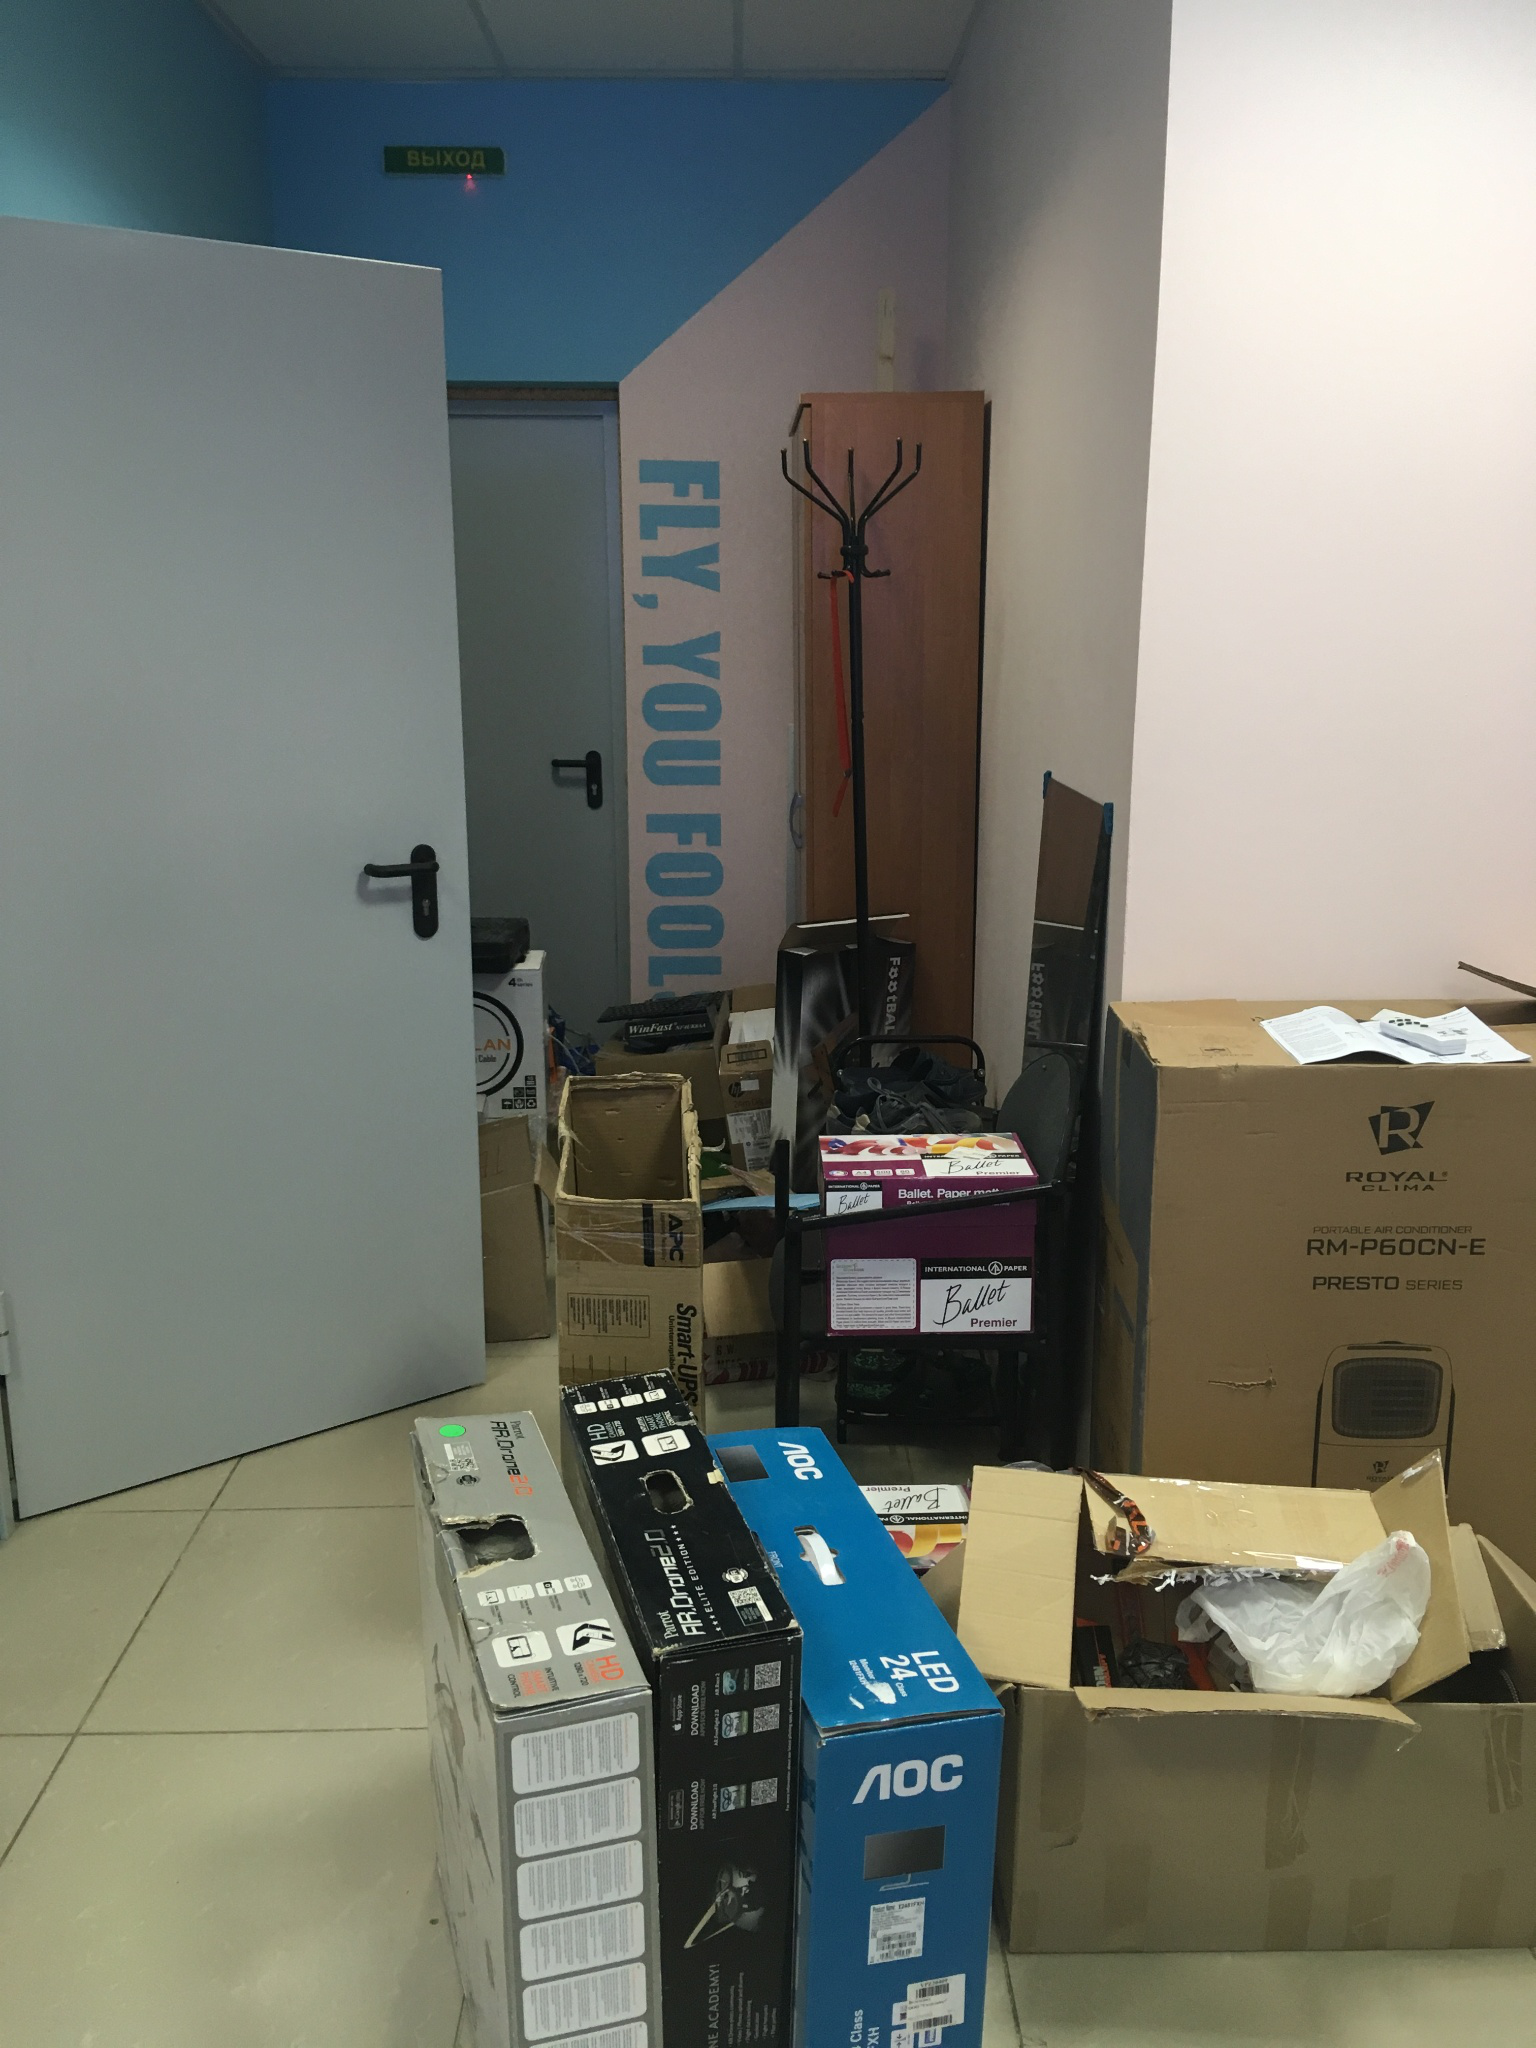

In [21]:
# Load the image
from PIL import Image
import requests
from io import BytesIO

image='/content/blur_dataset_scaled/sharp/0_IPHONE-SE_S.JPG'


imgInit=Image.open(image)
imgInit.show()

In [22]:
good_frames = '/content/blur_dataset_scaled/defocused_blurred'
bad_frames = '/content/blur_dataset_scaled/sharp'

In [23]:
clean_frames = []

for file in tqdm(sorted(os.listdir(good_frames))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size=(128,128))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    clean_frames.append(image)

clean_frames = np.array(clean_frames)

100%|██████████| 350/350 [00:19<00:00, 17.54it/s]


In [24]:
blurry_frames = []
for file in tqdm(sorted(os.listdir(bad_frames))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(128,128))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

100%|██████████| 350/350 [00:20<00:00, 17.02it/s]


Importing Libraries for the Model

In [25]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import backend as K

seed = 21
random.seed = seed
np.random.seed = seed

In [26]:
#Splitting the Dataset into Train and Test sets

X = clean_frames;
y = blurry_frames;

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Checking the shape of the train and test datasets

print(X_train[0].shape)
print(y_train[0].shape)

(128, 128, 3)
(128, 128, 3)


87


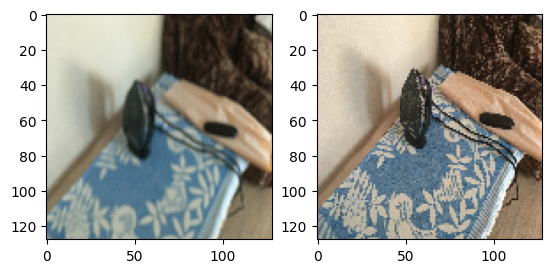

In [28]:
# Viewing the blur and clean image side by side

r = random.randint(0, len(clean_frames)-1)
print(r)

fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frames[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurry_frames[r])

In [29]:
# Network Parameters
input_shape = (128, 128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [30]:
# Building the Encoder Model

inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [32]:
# Instantiating the encoder model

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 latent_vector (Dense)       (None, 256)               16777472  
                                                                 
Total params: 17,148,288
Trainable params: 17,148,288
Non-t

In [33]:
# Building the Decoder Model

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [34]:
# Instantiating the decoder model

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 65536)             16842752  
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 64)     7379

Creating the AutoEncoder model by combining Encoder and Decoder model

In [36]:
# Instantiating the Autoencoder model

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 256)               17148288  
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       17803395  
                                                                 
Total params: 34,951,683
Trainable params: 34,951,683
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Choose Hyperparameters

autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

# Define Learning Rate reducer to reduce learning rate if no improvement in metric

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

callbacks = [lr_reducer]

Train the Model

In [41]:
history = autoencoder.fit(X_train,
                      y_train,
                      validation_data=(X_test, y_test),
                      epochs=100,
                      batch_size=batch_size,
                      callbacks=callbacks)

Epoch 1/100
7/7 [==============================] - 48s 7s/step - loss: 0.0704 - acc: 0.6595 - val_loss: 0.0676 - val_acc: 0.6106 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 41s 6s/step - loss: 0.0689 - acc: 0.6823 - val_loss: 0.0659 - val_acc: 0.6106 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 41s 6s/step - loss: 0.0671 - acc: 0.6823 - val_loss: 0.0637 - val_acc: 0.6106 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 40s 6s/step - loss: 0.0633 - acc: 0.6271 - val_loss: 0.0556 - val_acc: 0.5821 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 42s 6s/step - loss: 0.0583 - acc: 0.6742 - val_loss: 0.0509 - val_acc: 0.6075 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - 40s 6s/step - loss: 0.0525 - acc: 0.6639 - val_loss: 0.0487 - val_acc: 0.5743 - lr: 0.0010
Epoch 7/100
7/7 [==============================] - 42s 6s/step - loss: 0.0474 - acc: 0.6700 - val_loss: 0.0450 - val_acc: 0.6106 - lr: 0.0010
Epoch 


       Input                        Ground Truth                  Predicted Value
1/1 [==============================] - 0s 133ms/step


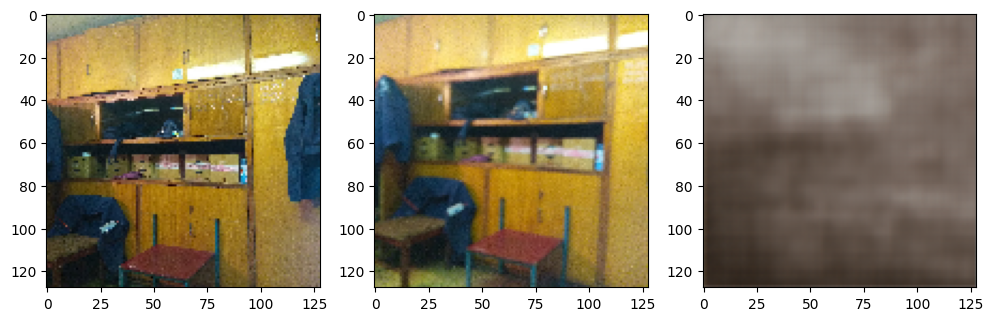

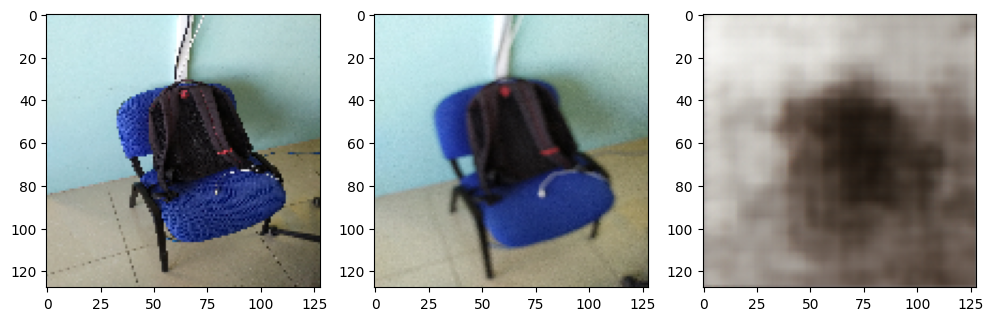

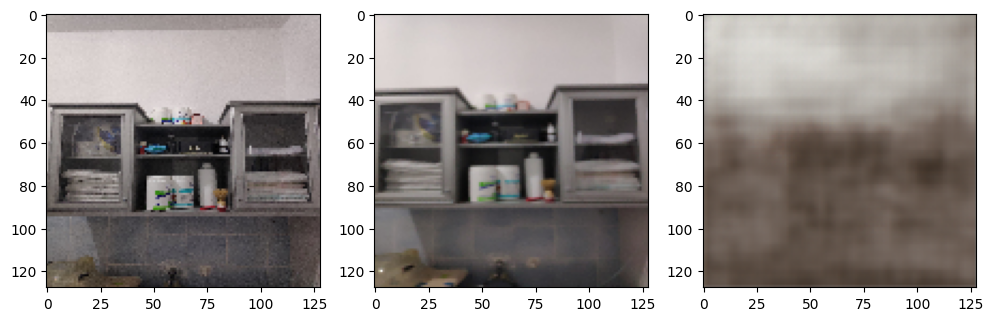

In [42]:
# Look at results

print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3):
    
    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp = x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)

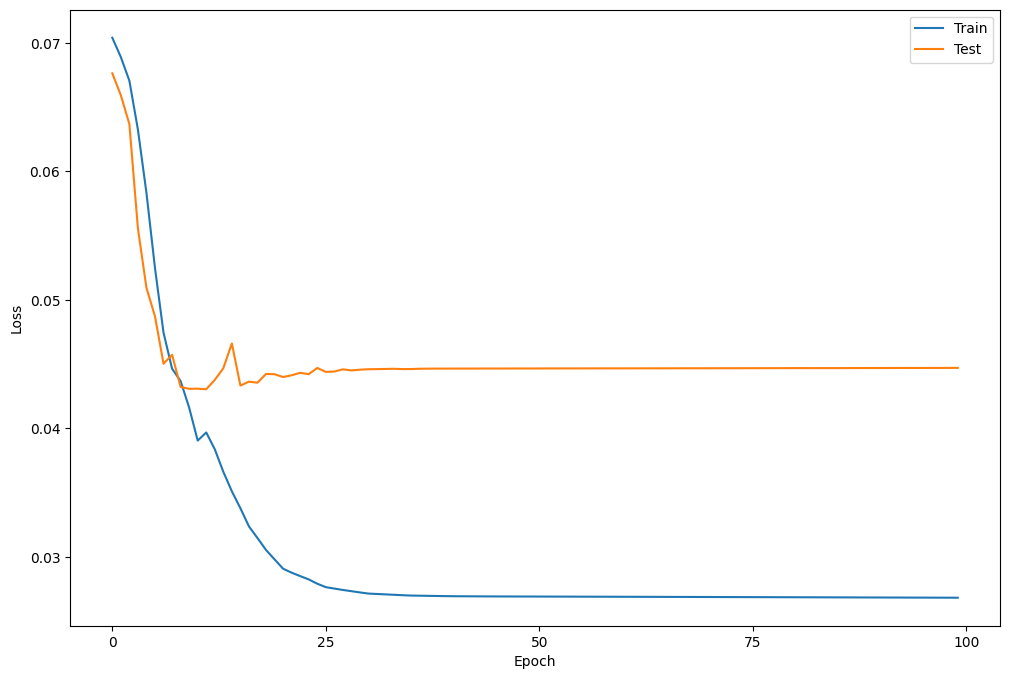

In [43]:
# Loss vs Epoch

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 101, 25))
plt.show()

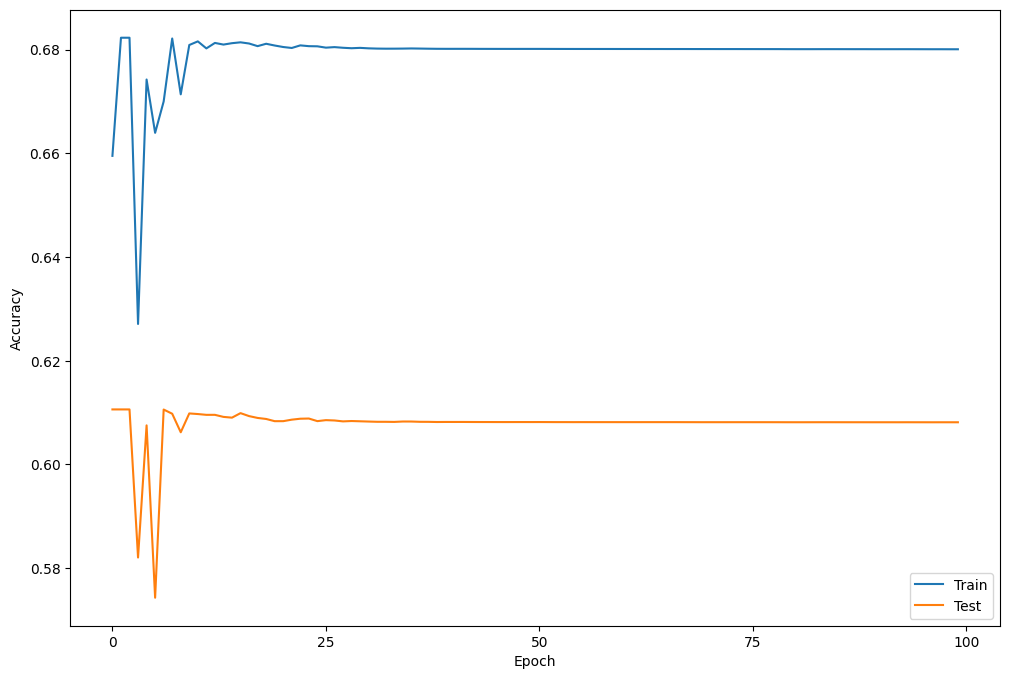

In [44]:
# Accuracy vs Epoch

plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 101, 25))
plt.show()